In [1]:
%pip install ipympl


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Run this in its own cell BEFORE plotting
from IPython import get_ipython

def enable_notebook_interaction():
    ip = get_ipython()
    if not ip:
        print("Not running inside IPython/Jupyter.")
        return
    try:
        import ipympl  # needs: pip install ipympl
        ip.run_line_magic("matplotlib", "widget")
        print("✅ Using %matplotlib widget (ipympl). Click/drag now works.")
    except ImportError:
        ip.run_line_magic("matplotlib", "notebook")
        print("⚠️ ipympl not installed. Using %matplotlib notebook (less robust).\n"
              "Install ipympl for best results: pip install ipympl")

enable_notebook_interaction()


✅ Using %matplotlib widget (ipympl). Click/drag now works.


In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

# =========================
# Helpers / I/O
# =========================

def load_mat_file(file_path):
    """
    Load a MATLAB file, handling both v7.3 (HDF5) and earlier formats.
    """
    if not os.path.exists(file_path):
        print(f"Error: File not found - {file_path}")
        return None
    try:
        data = loadmat(file_path)
        print(f"Loaded non-v7.3 file: {file_path}")
        return data
    except NotImplementedError:
        try:
            with h5py.File(file_path, 'r') as f:
                print(f"Loaded v7.3 file: {file_path}")
                return {key: f[key][:] for key in f.keys() if not key.startswith('__')}
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            return None

def calculate_rms(signal, window_size=100):
    """
    Calculate 
      with a sliding window for a 1D signal.
    """
    signal = np.asarray(signal, dtype=float).flatten()
    signal = signal[np.isfinite(signal)]
    if len(signal) == 0:
        return np.array([])

    pad = window_size // 2
    padded = np.pad(signal, pad, mode='edge')
    rms = np.zeros(len(signal), dtype=float)

    for i in range(len(signal)):
        window = padded[i:i+window_size]
        rms[i] = np.sqrt(np.mean(window**2))
    return rms

def explore_mat_structure(file_path):
    """
    Quick exploration of what's in the MAT file.
    """
    data = load_mat_file(file_path)
    if data is None:
        return None

    print(f"\nStructure of {os.path.basename(file_path)}:")
    print("-" * 40)
    for key, value in data.items():
        if not key.startswith('__'):
            if isinstance(value, np.ndarray):
                print(f"{key}: {value.shape} - {value.dtype}")
                if value.size < 20:
                    print(f"  Values: {value.flatten()}")
                else:
                    flat_val = value.flatten()
                    print(f"  Sample values: {flat_val[:5]}...")
                    print(f"  Min: {np.min(flat_val)}, Max: {np.max(flat_val)}")
            else:
                print(f"{key}: {type(value)}")
    return data

# =========================
# EMG object->matrix converter
# =========================

def object_emg_to_matrix(obj_arr):
    """
    Convert an object/cell array of EMG channels (e.g., shape (8,2)) into a 2D float array (C, T).
    Each element is expected to be a 1D array-like time series. Channels are aligned to the shortest length.
    Returns shape (C, T), where C = number of non-empty cells.
    """
    if not isinstance(obj_arr, np.ndarray) or obj_arr.dtype != object:
        raise ValueError("object_emg_to_matrix expects a numpy object array (MATLAB cell-array-like).")

    flat = obj_arr.ravel()
    chans = []
    for elem in flat:
        arr = np.asarray(elem).squeeze()
        if arr.ndim > 1:
            arr = arr.reshape(-1)
        arr = arr.astype(float)
        arr = arr[np.isfinite(arr)]
        if arr.size > 0:
            chans.append(arr)

    if len(chans) == 0:
        return np.array([], dtype=float)

    L = min(len(c) for c in chans)
    M = np.vstack([c[:L] for c in chans])  # (C, T)
    return M

# =========================
# Debug helper
# =========================

def debug_signal(data, signal_key):
    """
    Debug a specific signal to understand its structure.
    """
    if signal_key not in data:
        print(f"Key '{signal_key}' not found. Available keys: {list(data.keys())}")
        return None

    signal = data[signal_key]
    print(f"\nDebugging signal '{signal_key}':")
    print(f"Type: {type(signal)}")
    print(f"Shape: {getattr(signal, 'shape', None)}")
    print(f"Dtype: {getattr(signal, 'dtype', None)}")
    print(f"Size: {getattr(signal, 'size', None)}")

    if isinstance(signal, np.ndarray) and signal.dtype == object:
        print("Object array detected - first few elements:")
        flat = signal.flatten()
        for i, obj in enumerate(flat[:5]):
            print(f"  Element {i}: type={type(obj)}, shape={getattr(obj, 'shape', 'no shape')}")
            if hasattr(obj, 'flatten'):
                obj_flat = np.asarray(obj).flatten()
                if len(obj_flat) > 0:
                    print(f"    First few values: {obj_flat[:3]}")
    elif hasattr(signal, 'flatten'):
        flat = signal.flatten()
        print(f"Flattened shape: {flat.shape}")
        if len(flat) > 0:
            print(f"First 5 values: {flat[:5]}")
            print(f"Is numeric: {np.issubdtype(flat.dtype, np.number)}")
            print(f"Has finite values: {np.any(np.isfinite(flat))}")
    return signal

# =========================
# Interactive selector with draggable vertical lines
# =========================

class SimpleSignalSelector:
    def __init__(self):
        # Data state
        self.current_signal = None          # 1D array used for plotting
        self.current_signal_matrix = None   # (C, T) if multi-channel
        self.current_rms = None

        # Matplotlib state
        self.fig = None
        self.ax = None

        # View state
        self._last_view = dict(channel_idx=None, combine="mean")

        # Line selection state
        self._max_lines = 4
        self._lines = []  # list of dicts: {'line': Line2D, 'x': int, 'anno': Annotation}
        self._dragging = None  # index of line being dragged or None
        self._press_event = None
        self._snap_click = True
        self._pixel_tol = 8  # pixels for "near a line"

        # Event connections
        self._cid_press = None
        self._cid_release = None
        self._cid_motion = None
        self._cid_key = None

    # ---------- Public API ----------

    def plot_signal(self, signal, signal_name="Signal", rms_window=100, figsize=(15, 6),
                    channel_idx=None, combine='mean'):
        """
        Plot a single signal (1D) or a combined view of a multi-channel EMG matrix.
        If 'signal' is an object array (e.g., 8x2), it will be converted to (C, T).
        - channel_idx: plot a specific channel (0..C-1). If None, combine by 'mean' or 'median'.
        - combine: 'mean' or 'median' for multi-channel view.
        """
        self._last_view = dict(channel_idx=channel_idx, combine=combine)

        # Normalize input
        if isinstance(signal, np.ndarray) and signal.dtype == object:
            M = object_emg_to_matrix(signal)
            if M.size == 0:
                print("No valid numeric data found in object array.")
                return None
            self.current_signal_matrix = M
            if channel_idx is not None and 0 <= channel_idx < M.shape[0]:
                signal_1d = M[channel_idx]
                signal_name = f"{signal_name} (ch {channel_idx})"
            else:
                signal_1d = np.median(M, axis=0) if combine == 'median' else np.mean(M, axis=0)
                signal_name = f"{signal_name} ({combine} of {M.shape[0]} ch)"
            signal = signal_1d
        elif isinstance(signal, np.ndarray) and signal.ndim == 2 and signal.dtype != object:
            M = signal.astype(float)
            if np.any(~np.isfinite(M)):
                M = M[:, np.all(np.isfinite(M), axis=0)]
            if M.size == 0:
                print("Numeric 2D array contains no finite data.")
                return None
            self.current_signal_matrix = M
            if channel_idx is not None and 0 <= channel_idx < M.shape[0]:
                signal = M[channel_idx]
                signal_name = f"{signal_name} (ch {channel_idx})"
            else:
                signal = np.median(M, axis=0) if combine == 'median' else np.mean(M, axis=0)
                signal_name = f"{signal_name} ({combine} of {M.shape[0]} ch)"
        else:
            signal = np.asarray(signal, dtype=float).flatten()
            signal = signal[np.isfinite(signal)]
            self.current_signal_matrix = None

        if signal.size == 0:
            print("Error: No valid signal data after processing")
            return None

        self.current_signal = signal
        try:
            self.current_rms = calculate_rms(signal, rms_window)
        except Exception:
            self.current_rms = np.zeros_like(signal)

        # Draw
        self.fig, self.ax = plt.subplots(1, 1, figsize=figsize)
        t = np.arange(len(signal))
        self.ax.plot(t, signal, 'b-', alpha=0.75, linewidth=0.9, label=signal_name)
        if not np.allclose(self.current_rms, 0):
            self.ax.plot(t, self.current_rms, 'r-', linewidth=1.5, alpha=0.9, label=f'{signal_name} (RMS)')
        self.ax.set_title(f'{signal_name} - Length: {len(signal)}')
        self.ax.set_xlabel('Sample Index')
        self.ax.set_ylabel('Amplitude')
        self.ax.legend()
        self.ax.grid(True, alpha=0.3)

        # Instructions
        self._draw_instructions()

        # Connect events
        self._connect_events()

        plt.tight_layout()
        plt.show()
        return self.fig

    def get_lines(self):
        """Return sorted integer x-positions of the current lines."""
        xs = sorted(int(d['x']) for d in self._lines)
        return xs

    def clear_lines(self):
        """Remove all lines from the plot."""
        for d in self._lines:
            d['line'].remove()
            if d.get('anno') is not None:
                d['anno'].remove()
        self._lines.clear()
        self._redraw()
        print("All lines cleared.")

    def undo_last_line(self):
        """Remove the most recently added line."""
        if not self._lines:
            print("No lines to remove.")
            return
        d = self._lines.pop()
        d['line'].remove()
        if d.get('anno') is not None:
            d['anno'].remove()
        self._redraw()
        print("Removed last line.")

    def extract_regions(self, signal=None):
        """
        Extract data between line pairs:
          If N lines = 0 or 1 -> []
          If N lines = 2 -> [region1]
          If N lines >= 4 -> [region1, region2] using the first two pairs after sorting.
        Regions are inclusive of the start index and exclusive of the end index.
        Returns a list of dicts with 'start_idx', 'end_idx', 'length', and 'data'.
        For multi-channel data, 'data' has shape (C, L); else (L,).
        """
        if signal is None:
            signal = self.current_signal_matrix if self.current_signal_matrix is not None else self.current_signal
        if signal is None:
            print("No signal available.")
            return []

        xs = self.get_lines()
        if len(xs) < 2:
            print("Need at least 2 lines to extract a region.")
            return []

        # Pair up after sorting: (x0,x1), (x2,x3)
        pairs = []
        for i in range(0, min(len(xs), 4), 2):
            if i+1 < len(xs):
                a, b = xs[i], xs[i+1]
                if a == b:
                    continue
                start, end = sorted((a, b))
                pairs.append((start, end))

        regions = []
        for idx, (start, end) in enumerate(pairs, 1):
            if start < 0 or end > (signal.shape[-1]):
                # clamp silently
                start = max(0, start)
                end = min(signal.shape[-1], end)
            if end <= start:
                continue
            if signal.ndim == 2:
                # (C, T)
                data = signal[:, start:end]
                length = data.shape[1]
            else:
                data = signal[start:end]
                length = data.shape[0]
            regions.append({
                'region_num': idx,
                'start_idx': start,
                'end_idx': end,
                'length': length,
                'data': data
            })
        return regions

    # ---------- Internal helpers ----------

    def _draw_instructions(self):
        txt = (
            "Left-click: add/move line (drag to adjust)\n"
            "Right-click or Delete/Backspace: remove nearest line\n"
            "Up to 4 lines → regions: [L1,L2], [L3,L4]\n"
            "Press 'u' to undo last line, 'c' to clear all"
        )
        self.ax.figure.text(
            0.02, 0.96, txt,
            fontsize=9, va='top', ha='left',
            bbox=dict(boxstyle="round", facecolor="whitesmoke", alpha=0.9)
        )

    def _connect_events(self):
        self._disconnect_events()
        self._cid_press = self.fig.canvas.mpl_connect('button_press_event', self._on_press)
        self._cid_release = self.fig.canvas.mpl_connect('button_release_event', self._on_release)
        self._cid_motion = self.fig.canvas.mpl_connect('motion_notify_event', self._on_motion)
        self._cid_key = self.fig.canvas.mpl_connect('key_press_event', self._on_key)

    def _disconnect_events(self):
        c = self.fig.canvas if self.fig is not None else None
        if not c:
            return
        for cid in (self._cid_press, self._cid_release, self._cid_motion, self._cid_key):
            if cid is not None:
                c.mpl_disconnect(cid)

    def _on_key(self, event):
        if self.ax is None or event.inaxes not in (self.ax, None):
            return
        if event.key in ('delete', 'backspace'):
            self._delete_nearest_line(event)
        elif event.key == 'u':
            self.undo_last_line()
        elif event.key == 'c':
            self.clear_lines()

    def _on_press(self, event):
        if event.inaxes != self.ax:
            return
        if event.button == 3:  # right-click delete nearest
            self._delete_nearest_line(event)
            return

        # left click: select existing line (if near) or add a new one
        xdata = event.xdata
        if xdata is None:
            return
        x_idx = self._snap_index(xdata)

        # near existing?
        line_idx = self._find_nearest_line_idx(event)
        if line_idx is not None:
            self._dragging = line_idx
            self._press_event = event
            return

        # add new if room
        if len(self._lines) >= self._max_lines:
            print(f"Already have {self._max_lines} lines. Delete or move existing ones.")
            return
        self._add_line(x_idx)

    def _on_motion(self, event):
        if self._dragging is None or event.inaxes != self.ax:
            return
        xdata = event.xdata
        if xdata is None:
            return
        x_idx = self._snap_index(xdata)
        self._move_line(self._dragging, x_idx)

    def _on_release(self, event):
        self._dragging = None
        self._press_event = None

    # ----- Line ops -----

    def _add_line(self, x_idx):
        ln = self.ax.axvline(x_idx, linestyle='--', linewidth=1.5, alpha=0.9)
        anno = self.ax.annotate(
            f"x={x_idx}", xy=(x_idx, 1.0), xycoords=("data", "axes fraction"),
            xytext=(4, -4), textcoords="offset points",
            ha="left", va="top", fontsize=9,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
        )
        self._lines.append({'line': ln, 'x': int(x_idx), 'anno': anno})
        self._redraw()
        print(f"Added line at x={x_idx}. Current lines: {self.get_lines()}")

    def _move_line(self, idx, x_idx):
        d = self._lines[idx]
        d['x'] = int(x_idx)
        d['line'].set_xdata([x_idx, x_idx])
        if d.get('anno') is not None:
            d['anno'].set_position((x_idx, 1.0))
            d['anno'].set_text(f"x={int(x_idx)}")
        self._redraw(lite=True)

    def _delete_nearest_line(self, event):
        idx = self._find_nearest_line_idx(event)
        if idx is None:
            print("No line near the click/key location to delete.")
            return
        d = self._lines.pop(idx)
        d['line'].remove()
        if d.get('anno') is not None:
            d['anno'].remove()
        self._redraw()
        print(f"Deleted a line. Current lines: {self.get_lines()}")

    # ----- Utils -----

    def _snap_index(self, x):
        if not self._snap_click:
            return x
        n = len(self.current_signal) if self.current_signal is not None else 0
        xi = int(round(x))
        xi = max(0, min(n - 1, xi))
        return xi

    def _find_nearest_line_idx(self, event):
        """Return index of nearest line within pixel tolerance, else None."""
        if not self._lines:
            return None
        x_click, _ = event.x, event.y
        trans = self.ax.transData
        nearest_idx = None
        nearest_dist = float('inf')
        for i, d in enumerate(self._lines):
            x_line = d['x']
            # data -> display coords
            x_disp, _ = trans.transform((x_line, 0))
            dist = abs(x_disp - x_click)
            if dist < nearest_dist:
                nearest_dist = dist
                nearest_idx = i
        if nearest_dist <= self._pixel_tol:
            return nearest_idx
        return None

    def _redraw(self, lite=False):
        if lite:
            self.fig.canvas.draw_idle()
        else:
            self.fig.canvas.draw_idle()

# =========================
# Convenience workflow
# =========================

def quick_plot(file_path, signal_key=None, rms_window=100, channel_idx=None, combine='mean'):
    """
    Quick plot of a signal from a MAT file.
    If the signal is an object array (8x2), it will be converted to (C, T) and plotted as specified.
    """
    data = load_mat_file(file_path)
    if data is None:
        return None

    # If no signal key specified, find the first numeric/obj array with enough size
    if signal_key is None:
        for key, value in data.items():
            if not key.startswith('__') and isinstance(value, np.ndarray):
                if value.dtype == object or (np.issubdtype(value.dtype, np.number) and value.size > 10):
                    signal_key = key
                    break

    if signal_key not in data:
        print(f"Signal key '{signal_key}' not found in file.")
        return None

    selector = SimpleSignalSelector()
    selector.plot_signal(
        data[signal_key],
        f"{os.path.basename(file_path)} - {signal_key}",
        rms_window,
        channel_idx=channel_idx,
        combine=combine
    )
    return selector, data

def save_selections_summary(selections_dict, filename="signal_selections.csv"):
    """
    Save a summary of line-defined regions to CSV (using selector.get_lines()).
    """
    rows = []
    for file_name, selector in selections_dict.items():
        xs = selector.get_lines()
        xs_sorted = sorted(xs)
        for i in range(0, min(len(xs_sorted), 4), 2):
            if i+1 < len(xs_sorted):
                start, end = xs_sorted[i], xs_sorted[i+1]
                rows.append({
                    'file': file_name,
                    'pair_index': i//2 + 1,
                    'start_idx': min(start, end),
                    'end_idx': max(start, end),
                    'length': abs(end - start)
                })
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"Selections summary saved to {filename}")
    return df

# =========================
# Usage banner
# =========================

print("=== EMG Plotter with Draggable Lines ===")
print("Usage:")
print("1) data = explore_mat_structure('your_file.mat')")
print("2) selector, data = quick_plot('your_file.mat', 'signal_key', channel_idx=None, combine='mean')")
print("   - Left-click to add/move a vertical line (drag to adjust).")
print("   - Right-click (or Delete/Backspace) near a line to delete it.")
print("   - Up to 4 lines; regions are [L1,L2] and [L3,L4] after sorting.")
print("   - Press 'u' to undo last line, 'c' to clear all lines.")
print("3) lines = selector.get_lines()  # sorted list of x indices")
print("4) regions = selector.extract_regions()  # list of up to two regions with data slices")

 

=== EMG Plotter with Draggable Lines ===
Usage:
1) data = explore_mat_structure('your_file.mat')
2) selector, data = quick_plot('your_file.mat', 'signal_key', channel_idx=None, combine='mean')
   - Left-click to add/move a vertical line (drag to adjust).
   - Right-click (or Delete/Backspace) near a line to delete it.
   - Up to 4 lines; regions are [L1,L2] and [L3,L4] after sorting.
   - Press 'u' to undo last line, 'c' to clear all lines.
3) lines = selector.get_lines()  # sorted list of x indices
4) regions = selector.extract_regions()  # list of up to two regions with data slices


In [3]:
data = explore_mat_structure('/Users/juliahagen/IntMS_EEG/data/P3/90Deg_F1_1_plateau_iAll_MUedit.mat_decomp_70It_FDI_DEMUSEEDIT_cut_C.mat')


Loaded non-v7.3 file: /Users/juliahagen/IntMS_EEG/data/P3/90Deg_F1_1_plateau_iAll_MUedit.mat_decomp_70It_FDI_DEMUSEEDIT_cut_C.mat

Structure of 90Deg_F1_1_plateau_iAll_MUedit.mat_decomp_70It_FDI_DEMUSEEDIT_cut_C.mat:
----------------------------------------
MUPulses: (1, 14) - object
  Values: [array([[ 71803,  72724,  73622,  74267,  75093,  76382,  77366,  78591,
          79445,  80898,  81891,  82667,  83644,  84478,  85406,  86486,
          87686,  88513,  89643,  90447,  91618,  92699,  93813,  94539,
          95639,  96527,  97435,  98675,  99580, 100537, 101757, 103022,
         103809, 104634, 105573, 106551, 107651, 108695, 109604, 110532,
         111779, 112754, 113582, 114819, 116198, 117302, 118116, 119098,
         120405, 121436, 122391, 123616, 124764, 125817, 127082, 128110,
         129039, 130140, 131134, 132188, 132907, 133763, 134682, 135502,
         136553, 137540, 138590, 139748, 140764, 141829, 142536, 143417,
         144429, 145445, 146194, 147175, 148093,

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def ref1d(x):
    """Minimal: get a clean 1D float array for ref_signal."""
    arr = np.asarray(x).squeeze()
    if isinstance(x, np.ndarray) and x.dtype == object:
        # assume single cell containing the vector
        arr = np.asarray(x.ravel()[0]).squeeze()
    return arr.astype(float)

def attach_and_plot_ref_simple(regions, data, ref_key="ref_signal", fs=None):
    """
    For each region: slice ref_signal[a:b], plot it (force signal), attach as region['ref_signal'].
    fs is optional, only used to label x-axis in seconds if provided.
    """
    if ref_key not in data:
        raise KeyError(f"'{ref_key}' not found in data.")
    ref = ref1d(data[ref_key])

    for R in regions:
        a, b = int(R['start_idx']), int(R['end_idx'])
        # clamp to bounds
        a = max(0, min(len(ref)-1, a))
        b = max(0, min(len(ref),   b))
        ref_slice = ref[a:b]

        # plot (ref only)
        L = len(ref_slice)
        x = (np.arange(L) / fs) if fs else np.arange(L)
        xlab = "Time (s)" if fs else "Sample"
        plt.figure(figsize=(12, 3))
        plt.plot(x, ref_slice, lw=1.0)
        plt.title(f"Region {R.get('region_num','?')} ref_signal  [{a}, {b})  L={L}")
        plt.xlabel(xlab); plt.ylabel("Force"); plt.grid(True, alpha=0.3)
        plt.show()

        # store
        R['ref_signal'] = ref_slice
    return regions


In [81]:
data = explore_mat_structure('../P5/90Deg_F2_1_plateau_iAll_MUedit.mat_decomp_120It_FDI_DEMUSEEDIT_cut_C.mat')

Loaded non-v7.3 file: ../P5/90Deg_F2_1_plateau_iAll_MUedit.mat_decomp_120It_FDI_DEMUSEEDIT_cut_C.mat

Structure of 90Deg_F2_1_plateau_iAll_MUedit.mat_decomp_120It_FDI_DEMUSEEDIT_cut_C.mat:
----------------------------------------
MUPulses: (1, 16) - object
  Values: [array([[ 62356,  64056,  65186,  66067,  66945,  68348,  69122,  69922,
          70934,  71818,  73743,  74641,  76231,  77182,  77923,  78749,
          79434,  80040,  80747,  81295,  81932,  82616,  83216,  83885,
          84394,  84913,  85572,  86351,  86863,  87542,  88250,  89062,
          89875,  90709,  91383,  92116,  92927,  93621,  94337,  95021,
          95746,  96412,  97076,  97699,  98419,  99065,  99724, 100313,
         101081, 101750, 102281, 102901, 103387, 104044, 104652, 105379,
         106154, 106784, 107696, 108168, 109035, 110017, 110635, 111330,
         112061, 112839, 113456, 114451, 115162, 116101, 116879, 117576,
         118270, 119363, 120332, 121260, 122633, 124374, 125599, 126382,
   

In [27]:
debug_signal(data, 'SIG')


Debugging signal 'SIG':
Type: <class 'numpy.ndarray'>
Shape: (8, 2)
Dtype: object
Size: 16
Object array detected - first few elements:
  Element 0: type=<class 'numpy.ndarray'>, shape=(1, 617998)
    First few values: [0.03763834 0.05493164 0.06510416]
  Element 1: type=<class 'numpy.ndarray'>, shape=(1, 617998)
    First few values: [0.06408691 0.06357829 0.07069905]
  Element 2: type=<class 'numpy.ndarray'>, shape=(1, 617998)
    First few values: [0.02950032 0.05340576 0.06306966]
  Element 3: type=<class 'numpy.ndarray'>, shape=(1, 617998)
    First few values: [0.03662109 0.04679362 0.05289713]
  Element 4: type=<class 'numpy.ndarray'>, shape=(1, 617998)
    First few values: [0.05187988 0.05849202 0.0696818 ]


array([[array([[0.03763834, 0.05493164, 0.06510416, ..., 0.0406901 , 0.0386556 ,
                0.03611246]], shape=(1, 617998), dtype=float32)                 ,
        array([[0.06408691, 0.06357829, 0.07069905, ..., 0.03560384, 0.03763834,
                0.02848307]], shape=(1, 617998), dtype=float32)                 ],
       [array([[0.02950032, 0.05340576, 0.06306966, ..., 0.03916422, 0.03458659,
                0.03814697]], shape=(1, 617998), dtype=float32)                 ,
        array([[0.03662109, 0.04679362, 0.05289713, ..., 0.03916422, 0.03662109,
                0.02950032]], shape=(1, 617998), dtype=float32)                 ],
       [array([[0.05187988, 0.05849202, 0.0696818 , ..., 0.02237956, 0.03306071,
                0.03153483]], shape=(1, 617998), dtype=float32)                 ,
        array([[0.04781087, 0.06154378, 0.07832845, ..., 0.03712972, 0.03051758,
                0.03662109]], shape=(1, 617998), dtype=float32)                 ],
       [array([[0.0

Loaded non-v7.3 file: ../P3/180Deg_F2_1_plateau_iAll_MUedit.mat_decomp_70It_FDI_DEMUSEEDIT_cut_C.mat


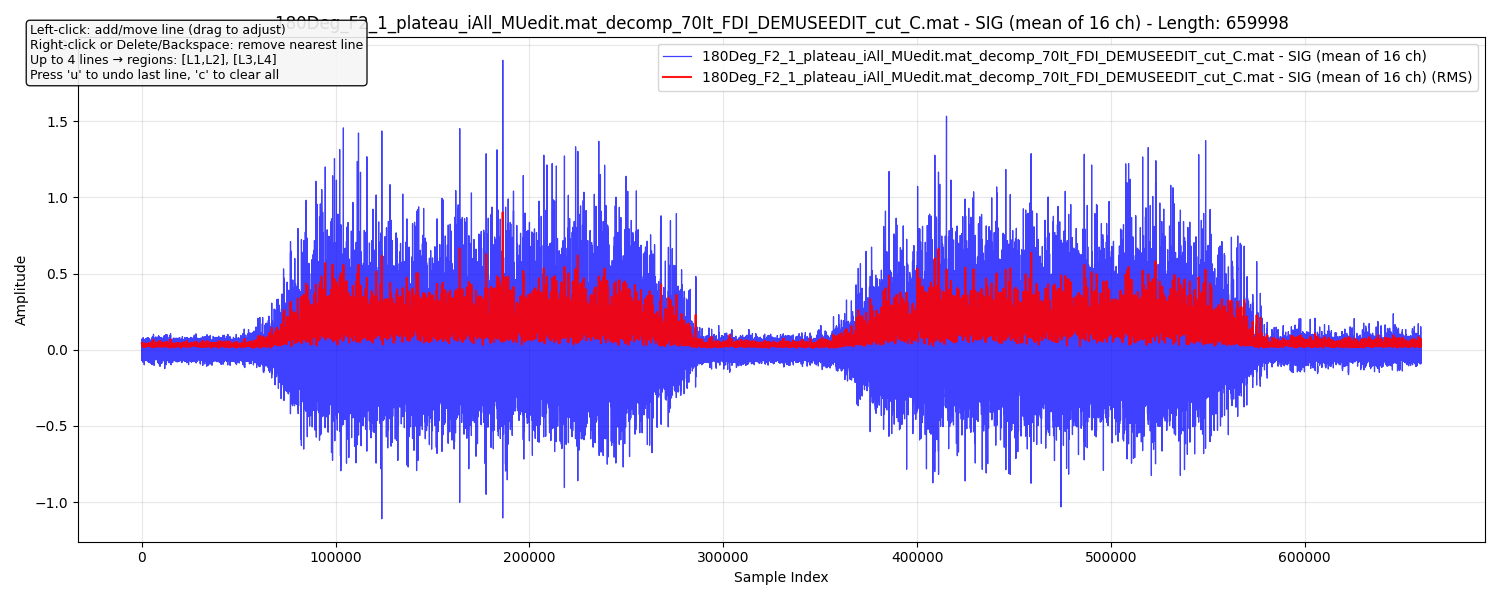

Added line at x=60020. Current lines: [60020]
Added line at x=288587. Current lines: [60020, 288587]
Added line at x=357209. Current lines: [60020, 288587, 357209]
Added line at x=580101. Current lines: [60020, 288587, 357209, 580101]


In [224]:
selector, data = quick_plot('../P3/180Deg_F2_1_plateau_iAll_MUedit.mat_decomp_70It_FDI_DEMUSEEDIT_cut_C.mat','SIG') 

In [227]:
print(selector.get_lines())        # e.g., [120, 350, 800, 1200]
regions = selector.extract_regions()

[52281, 288587, 345342, 580101]


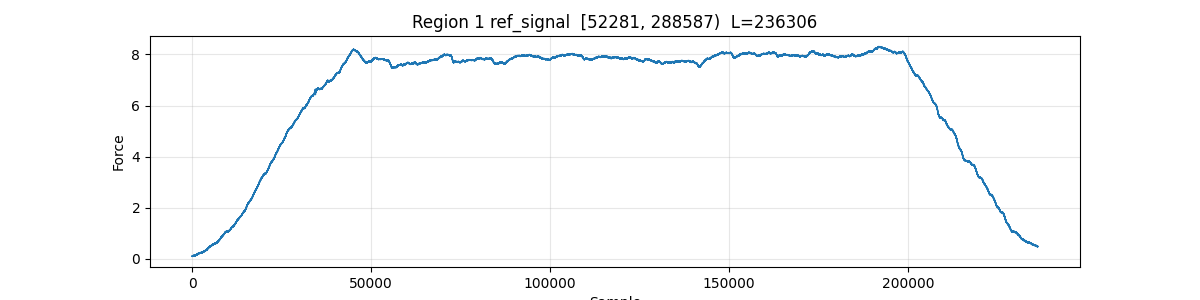

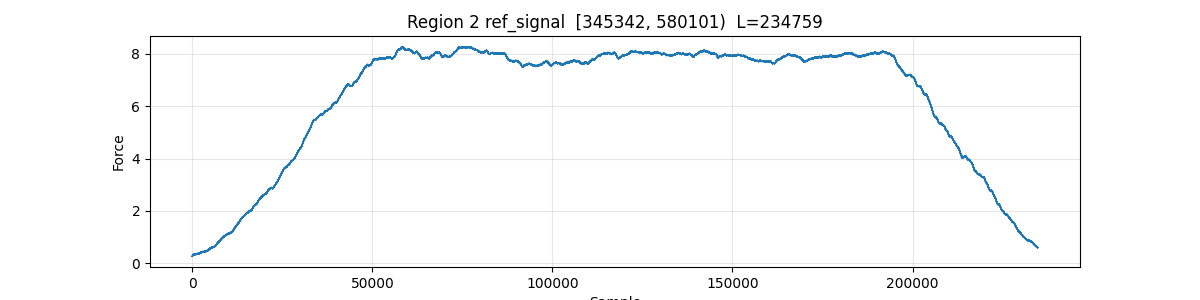

In [228]:
# you already have `regions` (two entries with start_idx/end_idx)
regions = attach_and_plot_ref_simple(regions, data, ref_key="ref_signal", fs=None)  # set fs if you want seconds


In [136]:
regions

[{'region_num': 1,
  'start_idx': 54264,
  'end_idx': 295127,
  'length': 240863,
  'data': array([[ 0.05798339,  0.04781087,  0.05594889, ..., -0.06561279,
          -0.07171631, -0.08392334],
         [ 0.04272461,  0.03611246,  0.03611246, ..., -0.05798339,
          -0.06510416, -0.08341471],
         [ 0.0600179 ,  0.0483195 ,  0.05137125, ..., -0.04526774,
          -0.05340576, -0.07171631],
         ...,
         [ 0.04679362,  0.02695719,  0.04119873, ..., -0.06256104,
          -0.07069905, -0.08850098],
         [ 0.03916422,  0.01831055,  0.0310262 , ..., -0.04475911,
          -0.04628499, -0.05900065],
         [ 0.05645752,  0.05086263,  0.06612141, ..., -0.05544027,
          -0.04933675, -0.06459554]], shape=(16, 240863)),
  'ref_signal': array([0.21029641, 0.21526295, 0.21913522, ..., 0.59442413, 0.60739619,
         0.60432714], shape=(240863,))},
 {'region_num': 2,
  'start_idx': 330633,
  'end_idx': 580612,
  'length': 249979,
  'data': array([[-0.0483195 , -0.0406

In [229]:
import os

# Create the new folder if it doesn't exist
output_folder = "P3_prp"
os.makedirs(output_folder, exist_ok=True)

# Save each region as a separate file
for region in regions:
    region_num = region['region_num']
    file_name = f"180_F2_1_{region_num}.npy"
    file_path = os.path.join(output_folder, file_name)
    
    # Save the region's data as a NumPy array
    np.save(file_path, region)
    print(f"Region {region_num} saved to {file_path}")

Region 1 saved to P3_prp/180_F2_1_1.npy
Region 2 saved to P3_prp/180_F2_1_2.npy


In [120]:
np.load('P5_prp/180_F2_1.npy', allow_pickle=True)

array({'region_num': 1, 'start_idx': 58094, 'end_idx': 325882, 'length': 267788, 'data': array([[-0.02187093, -0.02950032, -0.01678467, ...,  0.02034505,
        -0.00457764,  0.00559489],
       [-0.03153483, -0.03153483, -0.03255208, ...,  0.00305176,
        -0.01271566, -0.00864665],
       [-0.01729329, -0.02237956, -0.01881917, ...,  0.        ,
        -0.02848307, -0.01780192],
       ...,
       [-0.03712972, -0.03611246, -0.02339681, ...,  0.01678467,
        -0.00050863,  0.00203451],
       [-0.01678467, -0.01831055, -0.01373291, ...,  0.01373291,
        -0.01525879,  0.00457764],
       [-0.03153483, -0.02593994, -0.0116984 , ...,  0.0213623 ,
        -0.01068115,  0.00712077]], shape=(16, 267788)), 'ref_signal': array([0.39364919, 0.39364919, 0.38738489, ..., 0.13692731, 0.13638322,
       0.13893536], shape=(267788,))}, dtype=object)